# Load Oxford Street data

In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
calibration_file = '/content/drive/MyDrive/DLSS/TownCentre-calibration.ci'
groundtruth_file = '/content/drive/MyDrive/DLSS/TownCentre-groundtruth.top'
video_file = '/content/drive/MyDrive/DLSS/TownCentreXVID.mp4'


In [4]:
# Directory to save extracted frames
output_dir = '/content/extracted_frames'
os.makedirs(output_dir, exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(video_file)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Loop through all frames and save them as images
for frame_num in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break
    # Save frame as an image file
    frame_filename = f'frame_{frame_num}.jpg'
    frame_path = os.path.join(output_dir, frame_filename)
    cv2.imwrite(frame_path, frame)

cap.release()

# Open video file
cap = cv2.VideoCapture(video_file)

# Check if video file opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    # Read and display first frame
    ret, frame = cap.read()
    if ret:
        # Convert BGR to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title('First Frame of TownCentreXVID.mp4')
        plt.show()
    else:
        print("Error: Could not read frame.")

# Release video capture object
cap.release()

KeyboardInterrupt: 

In [ ]:
# extracted frames directory
frames_dir = '/content/extracted_frames'
annotations_path = groundtruth_file

# Load ground truth annotations if available
annotations = pd.read_csv(annotations_path, header=None, delimiter=',')
annotations.columns = ["personNumber", 'frame_num', 'label1', 'label2', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']

# Assuming your annotations have a format where each row corresponds to a frame
# and contains a label indicating presence of people (e.g., 0 or 1)
frame_files = os.listdir(frames_dir)
frame_paths = [os.path.join(frames_dir, fname) for fname in frame_files]
labels = []

# Extract labels from annotations based on frame numbers
for frame_path in frame_paths:
    frame_num = int(os.path.splitext(os.path.basename(frame_path))[0].split('_')[1])
    label = annotations.loc[frame_num, 'label1']
    labels.append(label)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(frame_paths, labels, test_size=0.2, random_state=42)

# Define transformations for images (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize if needed
])

# Create custom dataset class
class VideoFramesDataset(torch.utils.data.Dataset):
    def __init__(self, frame_paths, labels, transform=None):
        self.frame_paths = frame_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        img_path = self.frame_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label

# Create datasets and dataloaders
train_dataset = VideoFramesDataset(X_train, y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = VideoFramesDataset(X_val, y_val, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Check if each annotated frame number exists in the extracted frames
annotated_frames = annotations['frame_num'].unique()
extracted_frames = [int(os.path.splitext(fname)[0].split('_')[1]) for fname in os.listdir(output_dir)]

# Compare
missing_frames = [frame_num for frame_num in annotated_frames if frame_num not in extracted_frames]

# Print results
print(f"Total annotated frames according to annotations file: {len(annotated_frames)}")
print(f"Total frames extracted from video: {len(extracted_frames)}")
print(f"Frames missing annotations: {missing_frames}")

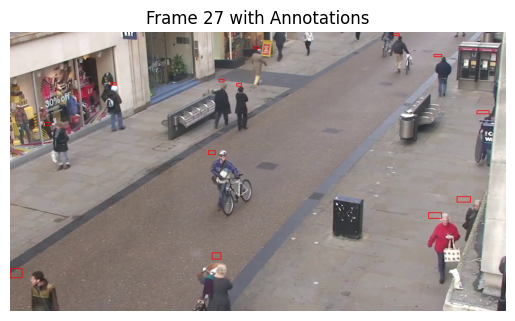

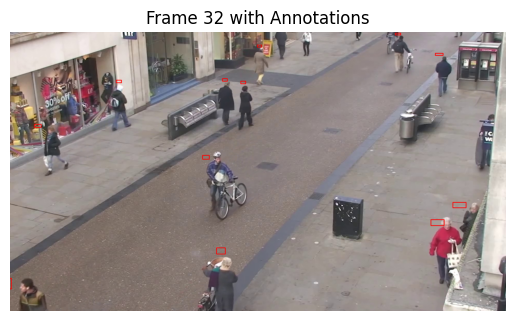

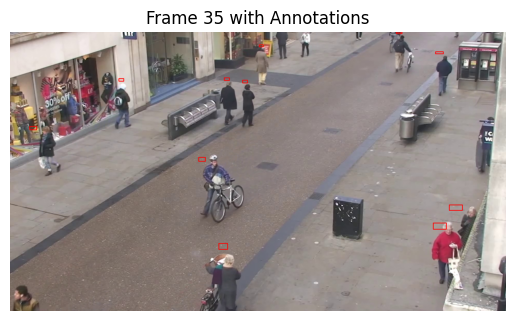

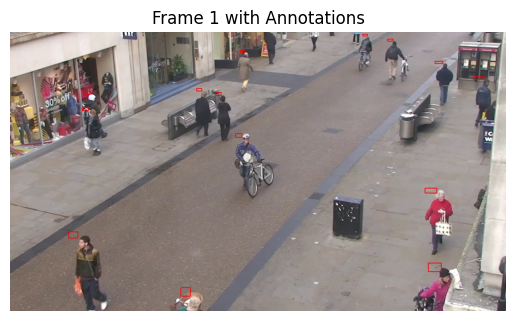

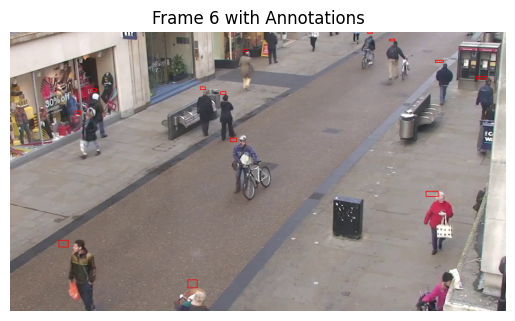

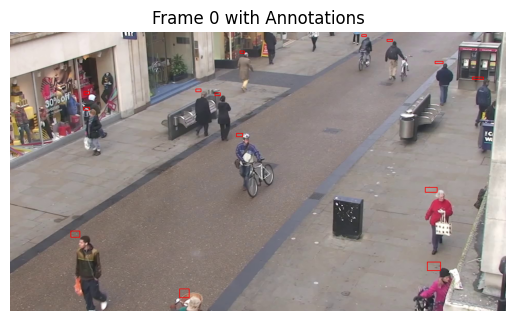

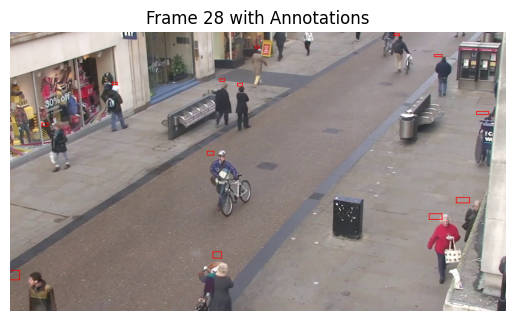

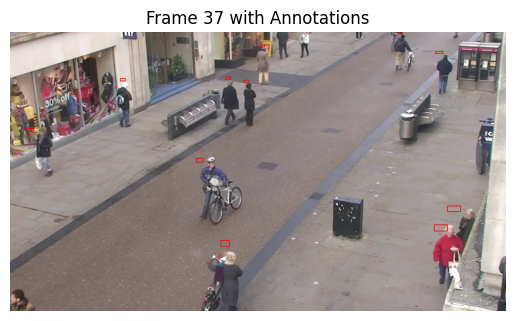

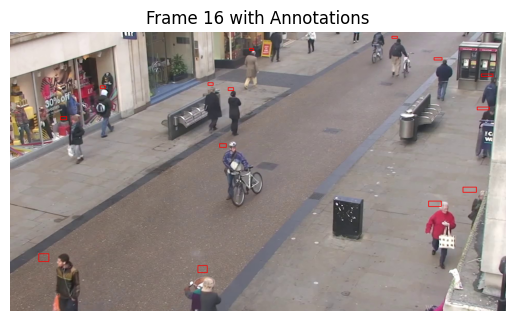

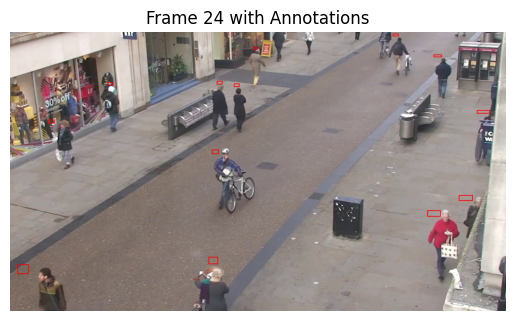

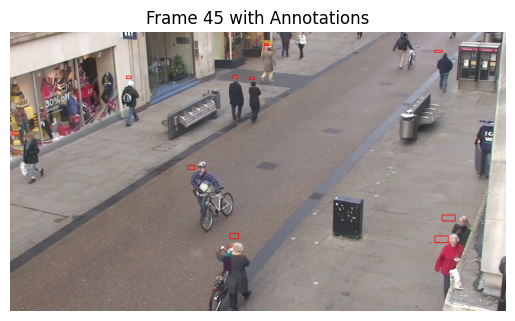

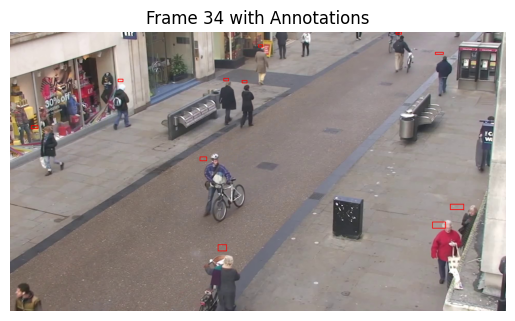

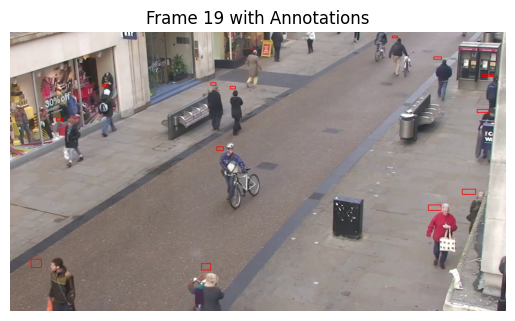

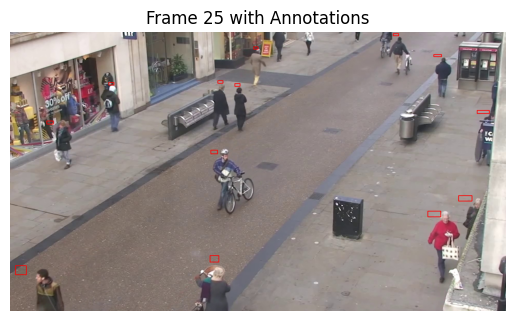

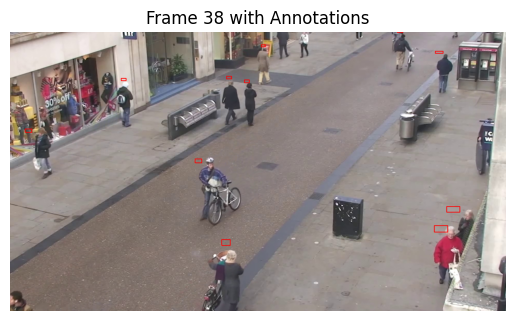

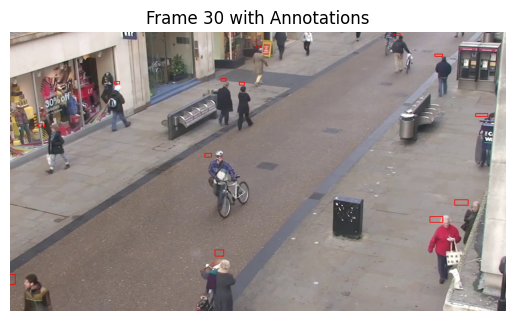

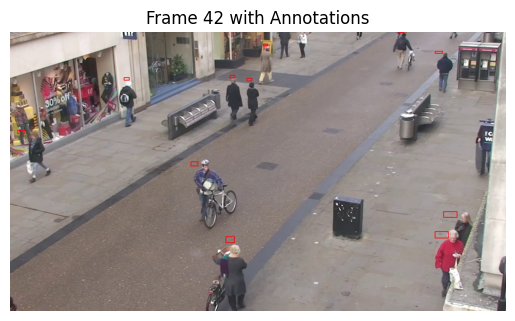

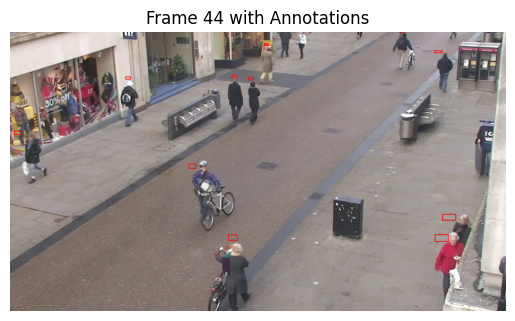

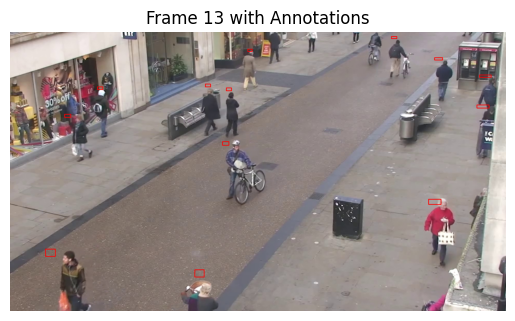

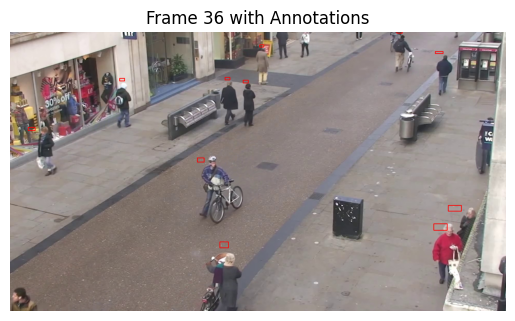

In [9]:
# Assuming groundtruth annotations are loaded into 'annotations' DataFrame
annotations_path = '/content/drive/MyDrive/DLSS/TownCentre-groundtruth.top'
annotations = pd.read_csv(annotations_path, header=None, delimiter=',')
annotations.columns = ['personNumber', 'frameNumber', 'headValid', 'bodyValid', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom']

# Directory where extracted frames are stored
frames_dir = '/content/extracted_frames'
frame_files = os.listdir(frames_dir)

# Verify annotations against extracted frames
for frame_file in frame_files[:20]:  # Check a sample of frames
    frame_num = int(os.path.splitext(frame_file)[0].split('_')[1])
    annotation = annotations.loc[annotations['frameNumber'] == frame_num]

    if not annotation.empty:
        # Display the frame with annotations (if possible)
        frame_path = os.path.join(frames_dir, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Example: Draw bounding boxes on the frame based on annotations
        for index, row in annotation.iterrows():
            # Extract coordinates from annotation
            x1, y1, x2, y2, x3, y3, x4, y4 = row[['headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom']]
            # Draw bounding box
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x3), int(y3)), (255, 0, 0), 2)

        # Display frame with annotations
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f'Frame {frame_num} with Annotations')
        plt.show()


## The Model

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)  # binary classification (person or not)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten tensor
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model
model = CNNModel()


In [ ]:
# loss function
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Squeeze outputs if necessary
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(torch.sigmoid(outputs))  # Binary prediction
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/DLSS/my_cnn_model2.pth')


Epoch [1/2], Loss: 6.1460
Validation Loss: 6.1338, Validation Accuracy: 0.0653
Epoch [2/2], Loss: 6.1460
Validation Loss: 6.1338, Validation Accuracy: 0.0653
